## 0.0 Imports

In [65]:
import sweetviz
import inflection
import warnings

import numpy   as np
import pandas  as pd
import seaborn as sns

from sklearn                   import metrics       as mt
from xgboost                   import XGBClassifier
from lightgbm                  import LGBMClassifier
from catboost                  import CatBoostClassifier
from sklearn.ensemble          import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing     import LabelEncoder
from sklearn.model_selection   import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.feature_selection import RFECV


warnings.filterwarnings('ignore')

### 0.1 Loading Data

In [2]:
df_raw = pd.read_csv('data/train.csv')

In [3]:
df_raw.head()

,id,Gender,Customer Type,Age,Type of Purchase,Store size,Store distance,InStore wifi,Open/Close time convenient,Easy of online shopping,...,Kids entertainment,Seller service,Showroom,Self-Store,Purchase service,Store Service,Cleanliness,Carrier delay in minutes,Delivery delay in minutes,Satisfaction
0,70172,Male,Loyal Customer,13,Personal,Small,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,Neutral or Dissatisfaction
1,5047,Male,disloyal Customer,25,Gift,Large,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,Neutral or Dissatisfaction
2,110028,Female,Loyal Customer,26,Gift,Large,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,Satisfied
3,24026,Female,Loyal Customer,25,Gift,Large,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,Neutral or Dissatisfaction
4,119299,Male,Loyal Customer,61,Gift,Large,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,Satisfied


### 0.2 Helper Functions

In [52]:
def data_cleaning(df1):
    
    cols_old = df1.columns
    cols_new = cols_old.map(lambda x: inflection.parameterize(x, separator='_'))
    df1.columns = cols_new
    
    df1 = df1.fillna(0)
    
    return df1

## 1.0 Data Description

In [37]:
df1 = df_raw.copy()

In [40]:
df1.sample(5)

,id,Gender,Customer Type,Age,Type of Purchase,Store size,Store distance,InStore wifi,Open/Close time convenient,Easy of online shopping,...,Kids entertainment,Seller service,Showroom,Self-Store,Purchase service,Store Service,Cleanliness,Carrier delay in minutes,Delivery delay in minutes,Satisfaction
100368,45753,Male,Loyal Customer,50,Gift,Medium,216,5,5,5,...,5,4,2,3,4,4,5,0,0.0,Satisfied
25715,91673,Female,Loyal Customer,55,Gift,Large,954,2,2,2,...,4,4,4,4,3,4,3,0,2.0,Satisfied
19124,30280,Male,Loyal Customer,56,Personal,Medium,1024,3,5,3,...,3,5,3,4,5,4,3,11,5.0,Neutral or Dissatisfaction
80925,42373,Male,Loyal Customer,55,Personal,Medium,834,2,5,2,...,5,4,4,4,5,4,5,30,15.0,Neutral or Dissatisfaction
65623,127777,Female,Loyal Customer,57,Gift,Large,3122,5,5,5,...,4,4,4,4,3,4,3,0,0.0,Satisfied


### 1.1 Data Shape

In [41]:
df1.shape

(103904, 24)

### 1.2 Rename Columns

In [42]:
data_cleaning(df1)

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,instore_wifi,open_close_time_convenient,easy_of_online_shopping,...,kids_entertainment,seller_service,showroom,self-store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal,Small,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,Neutral or Dissatisfaction
1,5047,Male,disloyal Customer,25,Gift,Large,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,Neutral or Dissatisfaction
2,110028,Female,Loyal Customer,26,Gift,Large,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,Satisfied
3,24026,Female,Loyal Customer,25,Gift,Large,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,Neutral or Dissatisfaction
4,119299,Male,Loyal Customer,61,Gift,Large,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,Satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,94171,Female,disloyal Customer,23,Gift,Medium,192,2,1,2,...,2,3,1,4,2,3,2,3,0.0,Neutral or Dissatisfaction
103900,73097,Male,Loyal Customer,49,Gift,Large,2347,4,4,4,...,5,5,5,5,5,5,4,0,0.0,Satisfied
103901,68825,Male,disloyal Customer,30,Gift,Large,1995,1,1,1,...,4,3,2,4,5,5,4,7,14.0,Neutral or Dissatisfaction
103902,54173,Female,disloyal Customer,22,Gift,Medium,1000,1,1,1,...,1,4,5,1,5,4,1,0,0.0,Neutral or Dissatisfaction


### 1.3 Check NaN

In [43]:
df1.isna().sum()

id                              0
gender                          0
customer_type                   0
age                             0
type_of_purchase                0
store_size                      0
store_distance                  0
instore_wifi                    0
open_close_time_convenient      0
easy_of_online_shopping         0
store_location                  0
toilet_cleaning                 0
dressing_room                   0
waiting_room                    0
kids_entertainment              0
seller_service                  0
showroom                        0
self-store                      0
purchase_service                0
store_service                   0
cleanliness                     0
carrier_delay_in_minutes        0
delivery_delay_in_minutes     310
satisfaction                    0
dtype: int64

In [44]:
df1 = df1.fillna(0)

In [45]:
df1.isna().sum()

id                            0
gender                        0
customer_type                 0
age                           0
type_of_purchase              0
store_size                    0
store_distance                0
instore_wifi                  0
open_close_time_convenient    0
easy_of_online_shopping       0
store_location                0
toilet_cleaning               0
dressing_room                 0
waiting_room                  0
kids_entertainment            0
seller_service                0
showroom                      0
self-store                    0
purchase_service              0
store_service                 0
cleanliness                   0
carrier_delay_in_minutes      0
delivery_delay_in_minutes     0
satisfaction                  0
dtype: int64

### 1.4 Change Types

In [11]:
df1.dtypes

id                              int64
gender                         object
customer_type                  object
age                             int64
type_of_purchase               object
store_size                     object
store_distance                  int64
instore_wifi                    int64
open_close_time_convenient      int64
easy_of_online_shopping         int64
store_location                  int64
toilet_cleaning                 int64
dressing_room                   int64
waiting_room                    int64
kids_entertainment              int64
seller_service                  int64
showroom                        int64
self-store                      int64
purchase_service                int64
store_service                   int64
cleanliness                     int64
carrier_delay_in_minutes        int64
delivery_delay_in_minutes     float64
satisfaction                   object
dtype: object

### 1.5 Descriptive Statistics

In [12]:
numerical_attributes = df1.select_dtypes(include=['float64','int64'])
categorical_attributes = df1.select_dtypes(exclude=['float64','int64'])

In [13]:
disp = numerical_attributes.agg(['min', 'max', lambda x: max(x) - min(x), 'mean', 'median','std','skew','kurtosis']).T.rename(columns={'<lambda>':'range'})
disp

,min,max,range,mean,median,std,skew,kurtosis
id,1.0,129880.0,129879.0,64924.210502,64856.5,37463.812252,0.002864,-1.198440
age,7.0,85.0,78.0,39.379706,40.0,15.114964,-0.004516,-0.719568
store_distance,31.0,4983.0,4952.0,1189.448375,843.0,997.147281,1.109466,0.268535
instore_wifi,0.0,5.0,5.0,2.729683,3.0,1.327829,0.040408,-0.846170
open_close_time_convenient,0.0,5.0,5.0,3.060296,3.0,1.525075,-0.334399,-1.037767
easy_of_online_shopping,0.0,5.0,5.0,2.756901,3.0,1.398929,-0.018294,-0.910346
store_location,0.0,5.0,5.0,2.976883,3.0,1.277621,-0.058889,-1.030283
toilet_cleaning,0.0,5.0,5.0,3.202129,3.0,1.329533,-0.151279,-1.145453
dressing_room,0.0,5.0,5.0,3.250375,3.0,1.349509,-0.453852,-0.702006
waiting_room,0.0,5.0,5.0,3.439396,4.0,1.319088,-0.482775,-0.925702


In [14]:
categorical_attributes

,gender,customer_type,type_of_purchase,store_size,satisfaction
0,Male,Loyal Customer,Personal,Small,Neutral or Dissatisfaction
1,Male,disloyal Customer,Gift,Large,Neutral or Dissatisfaction
2,Female,Loyal Customer,Gift,Large,Satisfied
3,Female,Loyal Customer,Gift,Large,Neutral or Dissatisfaction
4,Male,Loyal Customer,Gift,Large,Satisfied
...,...,...,...,...,...
103899,Female,disloyal Customer,Gift,Medium,Neutral or Dissatisfaction
103900,Male,Loyal Customer,Gift,Large,Satisfied
103901,Male,disloyal Customer,Gift,Large,Neutral or Dissatisfaction
103902,Female,disloyal Customer,Gift,Medium,Neutral or Dissatisfaction


In [15]:
# #sweetviz
# report = sweetviz.analyze(df1)
# report.show_html()

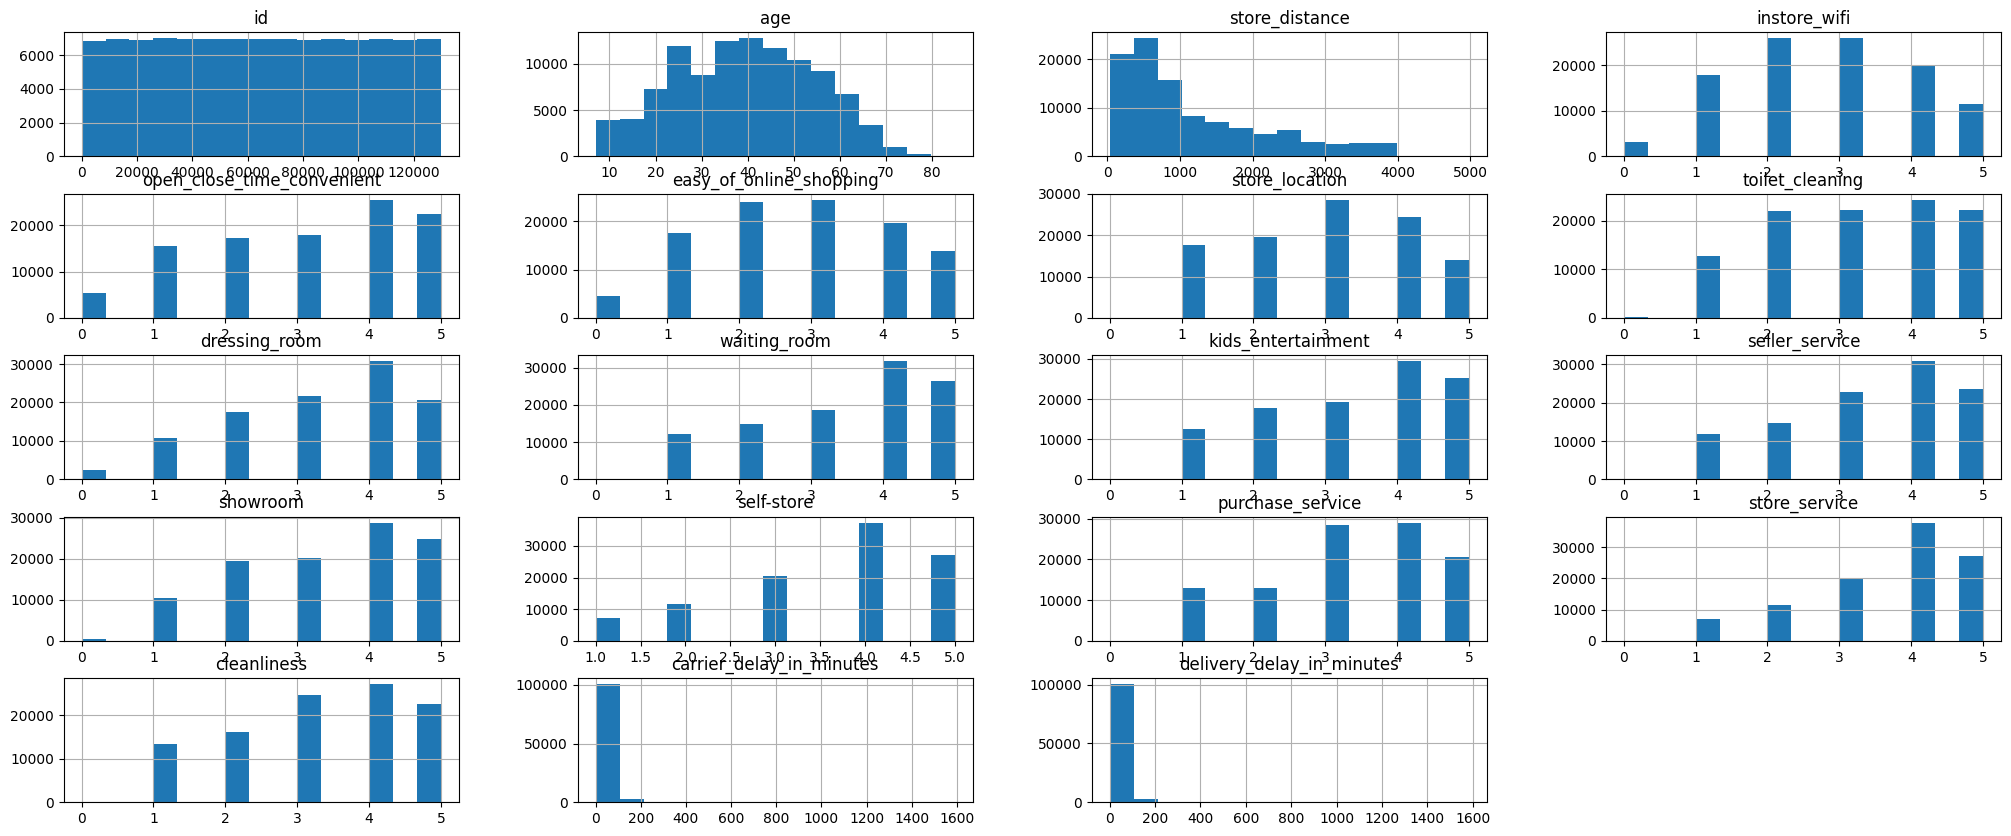

In [16]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
num_attributes.hist(bins=15, figsize=(25, 10));

## 2.0 Feature Engineering

In [35]:
df2 = df1.copy()

In [36]:
survey_features = ['instore_wifi', 'open_close_time_convenient', 'easy_of_online_shopping', 'store_location', 
                   'toilet_cleaning', 'dressing_room', 'waiting_room','kids_entertainment','seller_service', 'showroom', 'self-store', 
                   'purchase_service', 'store_service', 'cleanliness'
                  ]

df2['average_rating'] = df2[survey_features].mean(axis=1)
df2['max_rating'] = df2[survey_features].max(axis=1)
df2['min_rating'] = df2[survey_features].min(axis=1)
df2['var_rating'] = df2[survey_features].var(axis=1)
df2['count_positive'] = df2[survey_features].apply(lambda row: sum(row > 3), axis=1)
df2['count_negative'] = df2[survey_features].apply(lambda row: sum(row <= 3), axis=1)


## 3.0 EDA

In [19]:
df3 = df2.copy()

In [20]:
df3.head()

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,instore_wifi,open_close_time_convenient,easy_of_online_shopping,...,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,satisfaction,average_rating,max_rating,min_rating,var_rating,count_positive,count_negative
0,70172,Male,Loyal Customer,13,Personal,Small,460,3,4,3,...,5,25,18.0,Neutral or Dissatisfaction,3.857143,5,1,1.362637,9,5
1,5047,Male,disloyal Customer,25,Gift,Large,235,3,2,3,...,1,1,6.0,Neutral or Dissatisfaction,2.285714,5,1,1.758242,2,12
2,110028,Female,Loyal Customer,26,Gift,Large,1142,2,2,2,...,5,0,0.0,Satisfied,3.714286,5,2,1.604396,9,5
3,24026,Female,Loyal Customer,25,Gift,Large,562,2,5,5,...,2,11,9.0,Neutral or Dissatisfaction,3.000000,5,1,2.153846,5,9
4,119299,Male,Loyal Customer,61,Gift,Large,214,3,3,3,...,3,0,0.0,Satisfied,3.500000,5,3,0.576923,5,9


## 4.0 Pre-Processing

In [21]:
df4 = df3.copy()

In [22]:
le = LabelEncoder()

colunas = ['gender', 'customer_type', 'type_of_purchase', 'store_size']

for coluna in colunas:
    df4[coluna] = le.fit_transform(df4[coluna])

In [23]:
df4['satisfaction'] = df4['satisfaction'].apply(lambda x: 1 if x =='Satisfied' else 0)

In [27]:
selected_columns = ['id', 'customer_type', 'age', 'type_of_purchase', 'store_size',
                    'store_distance', 'instore_wifi', 'open_close_time_convenient',
                    'easy_of_online_shopping', 'store_location', 'dressing_room',
                    'waiting_room', 'kids_entertainment', 'seller_service', 'showroom',
                    'self-store', 'purchase_service', 'store_service', 'cleanliness',
                    'delivery_delay_in_minutes', 'average_rating', 'max_rating',
                    'min_rating', 'var_rating', 'count_positive', 'count_negative']

## 5.0 Machine Learning

In [56]:
df5 = df4.copy()

### 5.1 Split Train-Validation

In [57]:
X = df5.loc[:,selected_columns].copy()

y = df5['satisfaction'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### 5.2 Test Models

In [33]:
# model_list = [RandomForestClassifier,
#              XGBClassifier,
#              CatBoostClassifier,
#              LGBMClassifier]

# for model in model_list:
#     if model.__name__ == 'CatBoostClassifier':
#         mds = model(verbose=False)
#     else:
#         mds = model()
#     kfold = KFold(n_splits=10)
#     s = cross_val_score(mds, X, y, scoring='precision_micro', cv=kfold)
#     print(f"{model.__name__:22} Precision_micro: {s.mean():.5f} +/- {s.std():.3f} ")

### 5.3 XGboost

In [58]:
#define model
xgb_model = XGBClassifier()

#train model
xgb_model.fit(X_train, y_train)

#predict
yhat_xgb = xgb_model.predict(X_val)
xgb_metrics = mt.precision_score(y_val, yhat_xgb, average='micro')

### 5.4 Random Forest

In [59]:
#define model
rf_model = RandomForestClassifier()

#train model
rf_model.fit(X_train, y_train)

#predict
yhat_rf = rf_model.predict(X_val)
rf_metrics = mt.precision_score(y_val, yhat_rf, average='micro')

### 5.5 CatBoost

In [60]:
#define model
cbc_model = CatBoostClassifier(verbose=False)

#train model
cbc_model.fit(X_train, y_train)

#predict
yhat_cat = cbc_model.predict(X_val)
cat_metrics = mt.precision_score(y_val, yhat_cat, average='micro')

### 5.6 LGBM

In [61]:
#define model
model_lgb = LGBMClassifier()

#train model
model_lgb.fit(X_train, y_train)

#predict
yhat_lgb = model_lgb.predict(X_val)
lgb_metrics = mt.precision_score(y_val, yhat_lgb, average='micro')

In [67]:
results = pd.DataFrame([xgb_metrics, cat_metrics, rf_metrics, lgb_metrics], index=['XGB', 'CAT', 'RFC', 'LGBM'])
results.columns = ['Resultado']
results = results.sort_values(by='Resultado', ascending=False)

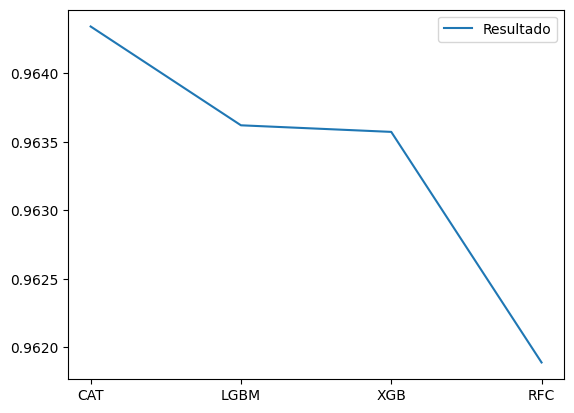

In [71]:
sns.lineplot(results);

## 6.0 Ensemble Learning

In [ ]:
df6 = df5.copy()

In [ ]:
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
xgb_model = XGBClassifier(random_state=42, n_jobs=-1)
lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1)
cbc_model = CatBoostClassifier(verbose=False)


voting_clf = VotingClassifier(
    estimators=[('random_forest', rf_model), ('xgboost', xgb_model),
                ('lgbm', lgbm_model), ('cbc', cbc_model)],
    voting='soft', # 'soft' usa probabilidades para votação, enquanto 'hard' usa rótulos
    weights=[1, 1, 1, 1], # Pode ser usado para ponderar a importância de cada classificador, como [2, 1, 3, ...]
    n_jobs=-1)

voting_clf.fit(X_train, y_train)

y_pred_vot = voting_clf.predict(X_val)

result = mt.precision_score(y_val, y_pred_vot, average='micro')
result

## 7.0 Submission

In [ ]:
X_test = pd.read_csv('data/test.csv')

In [ ]:
# X_test = data_cleaning(X_test)
# X_test = feature_eng(X_test)

In [ ]:
# colunas_test = ['gender', 'customer_type', 'type_of_purchase', 'store_size']

# for coluna in colunas_test:
#     X_test[coluna] = le.fit_transform(X_test[coluna])

### 7.1 Predict on test

In [ ]:
# X = X.loc[:, selected_columns]
# X_test = X_test.loc[:, selected_columns]

In [ ]:
# voting_clf.fit(X, y)

In [ ]:
# yhat_test = voting_clf.predict(X_test)
# submission_df = X_test.copy()
# submission_df['Satisfaction'] = yhat_test
# submission_df = submission_df.loc[:,['id','Satisfaction']]
# submission_df.to_csv('submission/submission_feat_eng_02.csv', index=False)